## Introduction

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator` and set it to `GPU`.

## Install Detectron2 and dependencies

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [ ]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

## COCO Format Dataset

### Download

We use `CribHD` dataset. Feel free to visit [CribHD](https://universe.roboflow.com/)

Structure of your dataset should look like this:

```
Blanket/

├─ train
│  ├─ train-image-1.jpg
│  ├─ train-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
├─ test
│  ├─ test-image-1.jpg
│  ├─ test-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
└─ valid
   ├─ valid-image-1.jpg
   ├─ valid-image-1.jpg
   ├─ ...
   └─ _annotations.coco.json
```

In [ ]:
# chnage directory to blanket dataset in CribHD
%cd <path to Blanket Dataset Directory>

### Register

When you use Detectron2, before you actually train the model you need to [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [ ]:
DATA_SET_NAME = "blanket"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [ ]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = 'train'
TRAIN_DATA_SET_ANN_FILE_PATH = 'train/_annotations.coco.json'

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = '/test'
TEST_DATA_SET_ANN_FILE_PATH = '/test/_annotations.coco.json'

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = '/valid'
VALID_DATA_SET_ANN_FILE_PATH = '/valid/_annotations.coco.json'

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

We can now confirm that our custom dataset was correctly registered using [MetadataCatalog](https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.MetadataCatalog).

In [ ]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['blanket-train', 'blanket-test', 'blanket-valid']

### Visualize

In [ ]:
import random
import cv2
import numpy as np
from detectron2.utils.visualizer import Visualizer, ColorMode

# Assuming TRAIN_DATA_SET_NAME is defined and the dataset is loaded
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

for _ in range(9):
    random_index = random.randint(0, len(dataset_train) - 1)
    dataset_entry = dataset_train[random_index]
    original_image = cv2.imread(dataset_entry["file_name"])

    visualizer = Visualizer(
        original_image[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )

    out = visualizer.draw_dataset_dict(dataset_entry)
    visualized_image = out.get_image()[:, :, ::-1]

    # Resize images to the same height
    height = max(original_image.shape[0], visualized_image.shape[0])
    original_resized = cv2.resize(original_image, (int(original_image.shape[1] * height / original_image.shape[0]), height))
    visualized_resized = cv2.resize(visualized_image, (int(visualized_image.shape[1] * height / visualized_image.shape[0]), height))

    # Concatenate the resized images side by side
    combined_image = np.hstack((original_resized, visualized_resized))
    cv2_imshow(combined_image)  # Display the combined image


## Train Model Using Custom COCO Format Dataset

### Configuration

In [ ]:
# HYPERPARAMETERS
ARCHITECTURE = "mask_rcnn_R_101_FPN_3x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
MAX_ITER = 6000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 2

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

### Training

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir $OUTPUT_DIR_PATH

### Evaluation

In [ ]:
cfg.MODEL.WEIGHTS = "<path to saved .pth file>"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

test_loader = build_detection_test_loader(cfg, "blanket-test")

# Create an evaluator (COCOEvaluator for datasets in COCO format)
evaluator = COCOEvaluator("blanket-test", cfg, False, output_dir="<path to output directory>")

# Run the evaluation
inference_on_dataset(predictor.model, test_loader, evaluator)

/content/data/20231211_131442(0).jpg


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


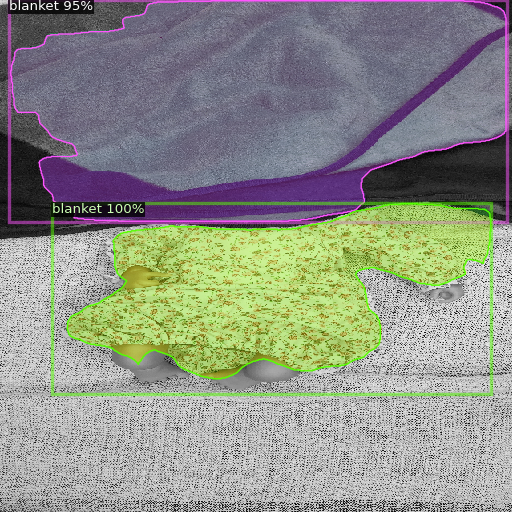

/content/data/20231211_131442.jpg


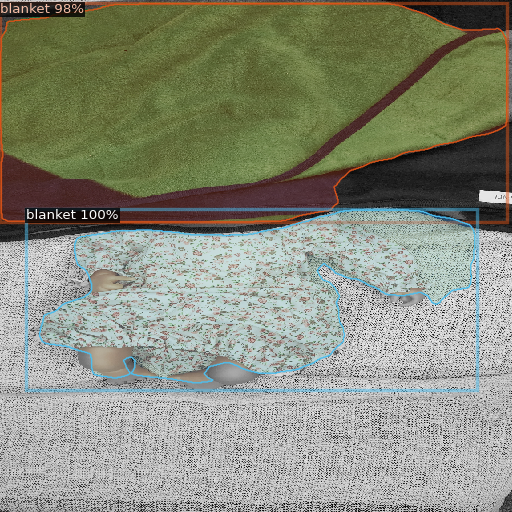

/content/data/20231211_131434.jpg


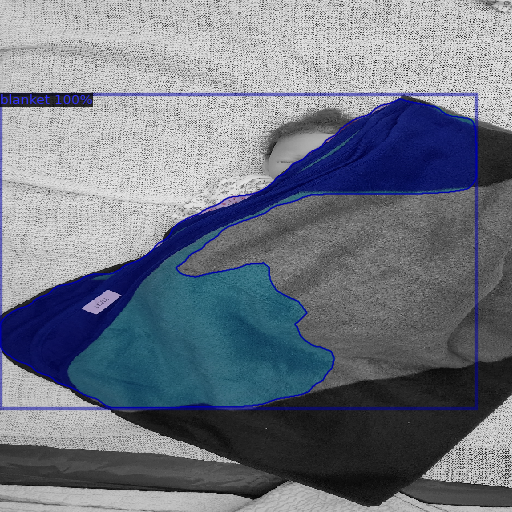

/content/data/20231211_115742.jpg


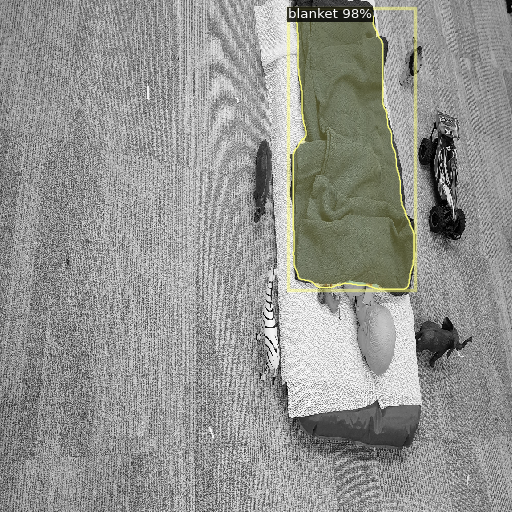

/content/data/20231211_115031.jpg


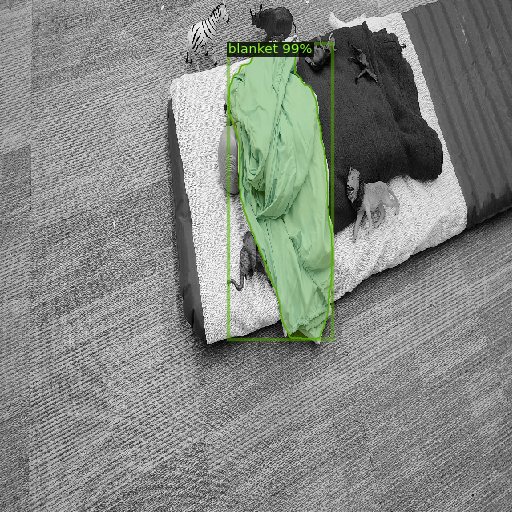

/content/data/20231211_115023.jpg


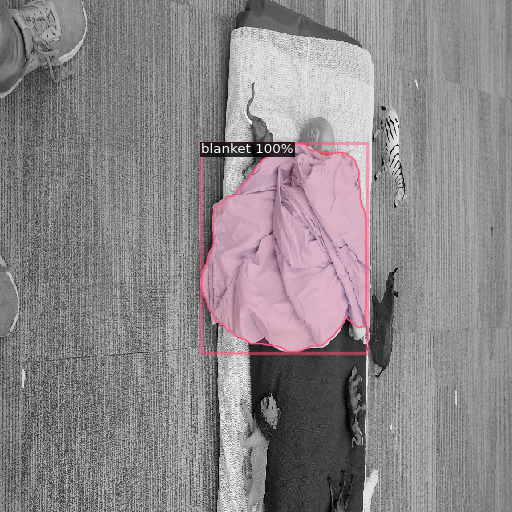

/content/data/20231211_120142.jpg


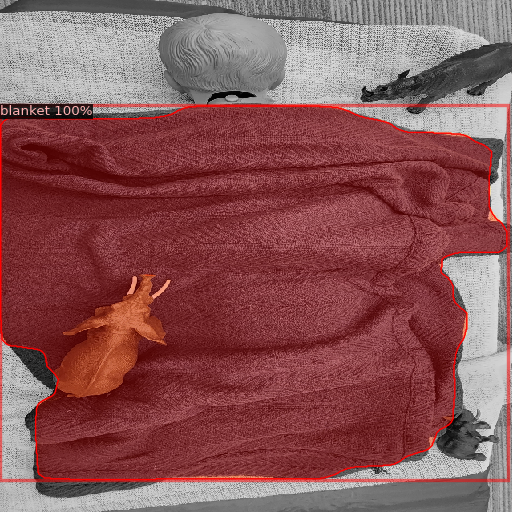

/content/data/20231211_115748.jpg


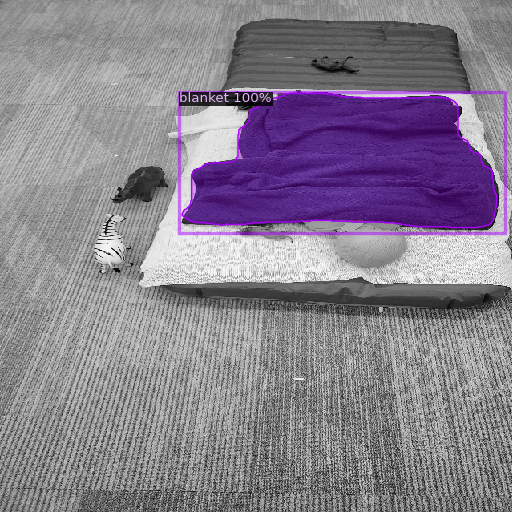

/content/data/20231211_115142.jpg


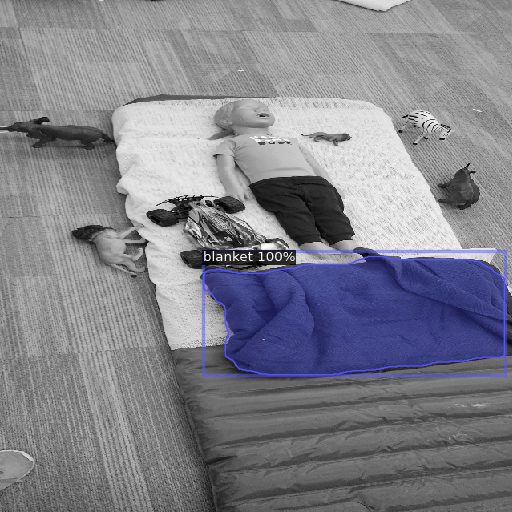

In [ ]:
import os
dataset = os.listdir('</path to images directory you want to test />')
for d in dataset:
    path = '</path to images directory you want to test />' + d
    # print(path)
    img = cv2.imread(path)
    img = cv2.resize(img, (640,640))
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])